In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

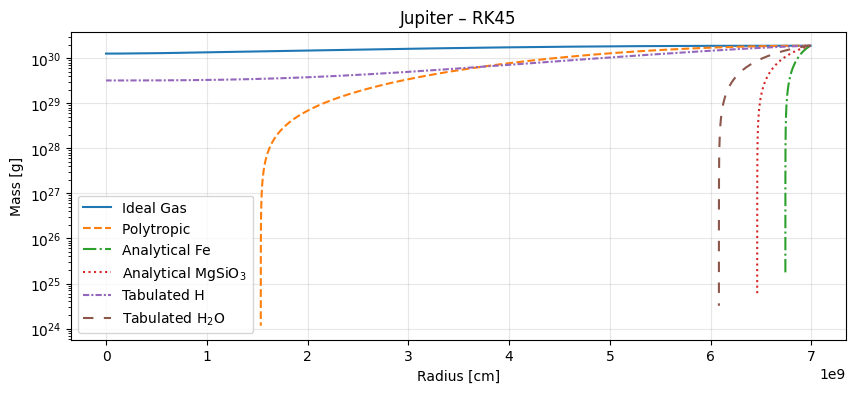

In [2]:
sim_names = {
    1 : '01_ideal_gas',
    2 : '02_polytropic',
    3 : '03_analytical_Fe',
    4 : '04_analytical_MgSiO3',
    5 : '05_tabulated_H',
    6 : '06_tabulated_H2O'
}

def nice_name(no):
    name = sim_names[no]
    name_parts = name.split('_')

    sim_name = ''
    for part in name_parts[1:]:
        if part == 'MgSiO3':
            part = 'MgSiO$_3$'
        elif part == 'H2O':
            part = 'H$_2$O'
        if part and part[0].islower():
            part = part[0].upper() + part[1:]
        sim_name += part + ' '
    return sim_name

planet = 'Jupiter'
# ------------------- load ------------------
datas = []
for no in [1,2,3,4,5,6]:
    file_name = f'{planet}_{sim_names[no]}_RK45_theta_2.csv'
    file_path = os.path.join('data', 'simulation_results', 'plot_4', file_name)
    data = np.loadtxt(file_path, skiprows=1, delimiter=',') 
    datas.append(data)

# ------------------- plot ------------------
linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 5))]
plt.figure(figsize=(10, 4))
for linestyle, no, data in zip(linestyles, [1,2,3,4,5,6], datas):
    name = nice_name(no)
    plt.plot(data[:,0], data[:,1], label=name, linestyle=linestyle)

plt.title('Jupiter \u2013 RK45')
plt.yscale('log')
plt.xlabel('Radius [cm]')
plt.ylabel('Mass [g]')
plt.grid(True, alpha=0.3)
plt.legend()

file_name = 'plot_4_different_EoS_x1.pdf'

folder_path = os.path.join('plots')
file_path = os.path.join(folder_path, file_name)
os.makedirs(folder_path, exist_ok=True)
plt.savefig(file_path)

plt.show()
plt.close()


C:\Users\felix\AppData\Local\Temp\ipykernel_10948\1569247455.py:51: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\felix\AppData\Local\Temp\ipykernel_10948\1569247455.py:58: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(file_path)
C:\Users\felix\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


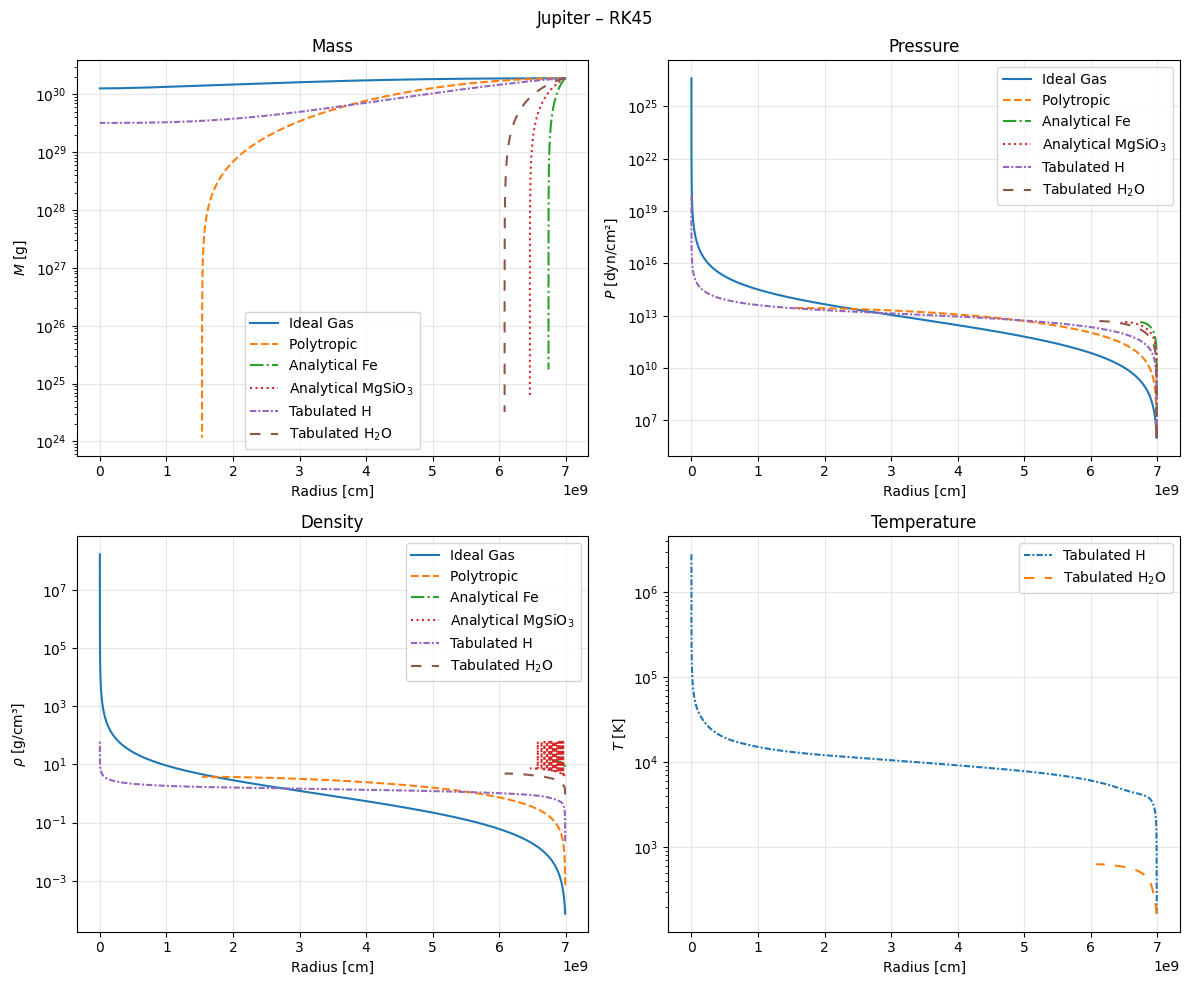

In [3]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

ax_mass, ax_p, ax_rho, ax_T = axs.ravel()

for linestyle, no, data in zip(linestyles, [1,2,3,4,5,6], datas):
    name = nice_name(no)

    # Mass
    ax_mass.plot(data[:,0], data[:,1], label=name, linestyle=linestyle)

    # Pressure
    ax_p.plot(data[:,0], data[:,2], label=name, linestyle=linestyle)

    # Density
    ax_rho.plot(data[:,0], data[:,3], label=name, linestyle=linestyle)

    # Temperature (only if last value != 0)
    if data[:,5][-1] != 0:
        ax_T.plot(data[:,0], data[:,5], label=name, linestyle=linestyle)

# ---------- Formatting ----------
ax_mass.set_title("Mass")
ax_mass.set_yscale('log')
ax_mass.set_xlabel("Radius [cm]")
ax_mass.set_ylabel("$M$ [g]")
ax_mass.grid(True, alpha=0.3)
ax_mass.legend()

ax_p.set_title("Pressure")
ax_p.set_yscale('log')
ax_p.set_xlabel("Radius [cm]")
ax_p.set_ylabel("$P$ [dyn/cm²]")
ax_p.grid(True, alpha=0.3)
ax_p.legend()

ax_rho.set_title("Density")
ax_rho.set_yscale('log')
ax_rho.set_xlabel("Radius [cm]")
ax_rho.set_ylabel("$\\rho$ [g/cm³]")
ax_rho.grid(True, alpha=0.3)
ax_rho.legend()

ax_T.set_title("Temperature")
ax_T.set_yscale('log')
ax_T.set_xlabel("Radius [cm]")
ax_T.set_ylabel("$T$ [K]")
ax_T.grid(True, alpha=0.3)
ax_T.legend()

plt.suptitle('Jupiter \u2013 RK45')
plt.tight_layout()

# Save
file_name = 'plot_4_different_EoS_x4.pdf'
folder_path = os.path.join('plots')
file_path = os.path.join(folder_path, file_name)
os.makedirs(folder_path, exist_ok=True)
plt.savefig(file_path)

plt.show()
plt.close()
